In [ ]:
# install efficientnet
!pip install efficientnet > /dev/null
!apt install libomp-dev > /dev/null
!pip install faiss > /dev/null
!pip install efficientnet > /dev/null

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/AC 215 Final Project/Code/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Imports

In [ ]:
import requests
import zipfile
import tarfile
import shutil
import math
import json
import time
import sys
import cv2
import glob
import string
import re
import subprocess
import hashlib
import numpy as np
import pandas as pd
from glob import glob
import collections
import unicodedata
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image

%matplotlib inline

from urllib.parse import urlparse

from efficientnet.tfkeras import EfficientNetB0

from deeplab.model import Deeplabv3

import pyarrow.parquet as pq
import pyarrow as pa
import faiss

# Tensorflow
import tensorflow as tf

In [ ]:
print("tensorflow version", tf.__version__, "\nkeras version", tf.keras.__version__)

tensorflow version 2.6.0 
keras version 2.6.0


In [ ]:
# change back to content directory
os.chdir('/content/')

## Define Helper Functions

In [ ]:
def download_file(packet_url, base_path="", extract=False, headers=None):
  if base_path != "":
    if not os.path.exists(base_path):
      os.mkdir(base_path)
  packet_file = os.path.basename(packet_url)
  with requests.get(packet_url, stream=True, headers=headers) as r:
      r.raise_for_status()
      with open(os.path.join(base_path,packet_file), 'wb') as f:
          for chunk in r.iter_content(chunk_size=8192):
              f.write(chunk)
  
  if extract:
    if packet_file.endswith(".zip"):
      with zipfile.ZipFile(os.path.join(base_path,packet_file)) as zfile:
        zfile.extractall(base_path)
    else:
      packet_name = packet_file.split('.')[0]
      with tarfile.open(os.path.join(base_path,packet_file)) as tfile:
        tfile.extractall(base_path)

In [ ]:
# retrive zipped file from GCP
start_time = time.time()

# Download and unzipe dataset
download_file("https://storage.googleapis.com/dogs_img/dogs.zip", 
              base_path="datasets", extract=True)

#### if have uploaded resized zip file, could uncomment below instead
# download_file("https://storage.googleapis.com/dogs_img/dogs_resized.zip", 
#               base_path="datasets", extract=True)

execution_time = (time.time() - start_time)/60.0
print("Download execution plus unzipping takes time (mins)",execution_time)

Download execution plus unzipping takes time (mins) 8.95952039162318


In [ ]:
# doload dogs medadata
start_time = time.time()

# Download dogs metadata
download_file("https://storage.googleapis.com/dogs_meta/data_dictionary.txt", base_path="datasets")
download_file("https://storage.googleapis.com/dogs_meta/dogs.csv", base_path="datasets")
download_file("https://storage.googleapis.com/dogs_meta/dogs_photos.csv", base_path="datasets")

execution_time = (time.time() - start_time)/60.0
print("Download dogs metadata takes time(mins)",execution_time)

Download dogs metadata takes time(mins) 0.0092515230178833


In [ ]:
datasets_path = 'datasets'
print('Total number of images:', len(glob(os.path.join(datasets_path, "dogs") + "/*/*.png")))

Total number of images: 65913


## Create reseized images, zip and upload to GCP

In [ ]:
resize_folder = 'dogs_resized'
IMG_SIZE = (224, 224)

start_time = time.time()
if not os.path.exists("./datasets/" + resize_folder):
  os.mkdir("./datasets/" + resize_folder)

for img in glob(os.path.join(datasets_path, "dogs") + "/*/*.png"):
  # grab image folder name
  pattern = re.compile(r".*/.*/(.*)/.*")
  match = pattern.match(img).group(1)
  
  if not os.path.exists("./datasets/" + resize_folder + '/' + match):
    os.mkdir("./datasets/" + resize_folder + '/' + match)

  image = cv2.imread(img)
  try:
    imgResized = cv2.resize(image, IMG_SIZE, interpolation = cv2.INTER_AREA)
    cv2.imwrite(os.path.join(datasets_path, resize_folder) + img[len(os.path.join(datasets_path, "dogs")):],
              imgResized)
  except:
    print(img)

execution_time = (time.time() - start_time)/60.0
print("\nresize images takes time(mins)",execution_time)

datasets/dogs/1513939/20170406210108.png
datasets/dogs/14133078/20191024062420.png
datasets/dogs/17785162/20191215174130.png
datasets/dogs/10756362/20190312223956.png
datasets/dogs/27765686/20201002090229.png
datasets/dogs/1513930/20170325233420.png
datasets/dogs/1623426/20170811204724.png
datasets/dogs/1515165/20170413145209.png
datasets/dogs/25781828/20200723130600.png
datasets/dogs/21970326/20200531093837.png
datasets/dogs/14387629/20190810105233.png
datasets/dogs/21982062/20200607213943.png
datasets/dogs/3256827/20180114093038.png
datasets/dogs/1517880/20170228143931.png
datasets/dogs/1696235/20170725163033_0.png

resize images takes time(mins) 34.0623070081075


In [ ]:
# delete above file
# os.remove('datasets/dogs_resized/21970326/20200531093837.png')

Note: The above images for some reason CV2 couldn't read in, so will leave them out when creating embedding later. 

In [ ]:
# check the number of resized images
print('Total number of resized images:', len(glob(os.path.join(datasets_path, "dogs_resized") + "/*/*.png")))

Total number of resized images: 65898


In [ ]:
# zip dogs resized directory
start_time = time.time()

zip_name = os.path.join(datasets_path, resize_folder)
directory_name = os.path.join(datasets_path, 'dogs_resized')
shutil.make_archive(zip_name, 'zip', directory_name)

execution_time = (time.time() - start_time)/60.0
print("zipping resized dog images takes time(mins)",execution_time)

zipping resized dog images takes time(mins) 5.575040793418884


In [ ]:
# upload it to GCP
!curl --upload-file ./datasets/dogs_resized.zip https://storage.googleapis.com/dogs_img/

## Data Exploration Analysis

In [ ]:
datasets_path = "datasets"

# Data Dictionary
data_dictionary_path = os.path.join(datasets_path,"data_dictionary.txt")
with open(data_dictionary_path, 'r') as file:
  data_dictionary = file.read()

print("Data Dictionary:")
print(data_dictionary)

Data Dictionary:
dogs.csv - one row for every dog taken into custody since 1/1/2017.
-fields:
—-"AnimalID" - public facing unique id
--"AnimalInternal-ID" - internal unique id - USE THIS to link to the other tables (dogs_photos.csv and dogs_website_memos.csv)
--"AnimalName" 
--"AnimalType" - always "Dog"
--"AnimalSex" - Male, Female or Unknown
--"AnimalCurrentWeightPounds" - decimal weight in pounds. NOTE: data quality of this field is mediocre at best. Staff are good about recording at least one weight around the time of intake but not as diligent about recording a weight prior to outcome.
--"AnimalDOB" -  DOB formatted as YYYYMMDD
--"AnimalBreed" - concatenation of primary and secondary breed fields delimited by " /". 
--"AnimalColor" - concatenation of primary and secondary colors fields delimited by " /". 
--"AnimalPattern" - animal pattern NOTE: not often populated for dogs. More often used for cats


dogs_photos.csv - one row for every photo uploaded to a dogs profile.
-fields:
-

In [ ]:
# dogs.csv
dogs_path = os.path.join(datasets_path,"dogs.csv")
dogs = pd.read_csv(dogs_path)
print("Shape:",dogs.shape)
dogs.head()

Shape: (17212, 10)


,AnimalID,AnimalInternal-ID,AnimalName,AnimalType,AnimalSex,AnimalCurrentWeightPounds,AnimalDOB,AnimalBreed,AnimalColor,AnimalPattern
0,45628,1444011,Emma,Dog,Female,53.3,20150306,"Retriever, Yellow Labrador /Mix",Blond /None,NaN
1,45629,1444014,Rizzoli,Dog,Female,4.7,20161222,Mixed Breed (Small),Tan /None,NaN
2,45630,1444017,Isles,Dog,Female,3.1,20161222,Mixed Breed (Small),White /None,NaN
3,45631,1444020,Cory,Dog,Male,4.7,20161222,Mixed Breed (Small),Sable /None,NaN
4,45632,1444023,Topanga,Dog,Female,8.0,20161222,Mixed Breed (Small),Tan /None,NaN


**Note**: In our dataset, we have 17212 dogs in total in the dataset. There're 10 features about each dog or animal. 

In [ ]:
# dogs_photos.csv
dogs_photos_path = os.path.join(datasets_path,"dogs_photos.csv")
dogs_photos = pd.read_csv(dogs_photos_path)
print("Shape:",dogs_photos.shape)
dogs_photos.head()

Shape: (65990, 2)


,AnimalInternal-ID,PhotoUrl
0,1444011,https://www.shelterluv.com/sites/default/files...
1,1444011,https://www.shelterluv.com/sites/default/files...
2,1444011,https://www.shelterluv.com/sites/default/files...
3,1444011,https://www.shelterluv.com/sites/default/files...
4,1444011,https://www.shelterluv.com/sites/default/files...


**Note**: For entire dog images, there are total 65990, which means that one dog could have multiple images. This dataset also contains the URL that can be used for retrieving the photo from the website. 

In [ ]:
dogs["AnimalBreed"].value_counts()

Terrier, Pit Bull/Mix                                                  912
Retriever, Labrador/Mix                                                868
Mixed Breed (Medium)                                                   703
Shepherd/Mix                                                           560
Chihuahua                                                              450
                                                                      ... 
Newfoundland/Retriever, Flat-Coated                                      1
Catahoula Leopard Dog/Great Dane                                         1
Pyrenees, Great/Retriever, Golden                                        1
Griffon, Brussels                                                        1
Cattle Dog, Australian (Red Heeler)/Terrier, American Staffordshire      1
Name: AnimalBreed, Length: 1501, dtype: int64

## Create TFRecords

Create TFRecords from resized dog images. TFRecords will be used as input to generate image embeddings.

In [ ]:
!ls -l datasets/dogs_resized.zip

-rw-r--r-- 1 root root 6304386641 Oct 19 00:56 datasets/dogs_resized.zip


In [ ]:
# Convert strings to bytes list
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()  # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

# Function to serialize the image and image name to string
def serialize_example(image, image_name):
    feature = {
        'image_name': _bytes_feature(image_name),
        'image': _bytes_feature(image)
    }

    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

# Generate serilaized datapoint
def tf_serialize_example(image, image_name):
    tf_string = tf.py_function(
        serialize_example,
        (image, image_name),
        tf.string)
    return tf.reshape(tf_string, ())

# Extract the image name and read the image file   
def process_path(file_path):
    parts = tf.strings.split(file_path, '/')
    image_name = tf.strings.split(parts[-1], '.')[0]
    raw = tf.io.read_file(file_path)
    return raw, image_name

# Write the TFRecord to the current shard
def read_image_file_write_tfrecord(files_ds, output_filename):
    image_ds = files_ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    serialized_features_dataset = image_ds.map(tf_serialize_example, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    writer = tf.data.experimental.TFRecordWriter(output_filename)
    writer.write(serialized_features_dataset)

# Function to create shards and call to generate TFRecrods
def image_files_to_tfrecords(list_ds, output_folder, num_shard):
    start = time.time()
    for shard_id in range(0, num_shard):
        shard_list = list_ds.shard(num_shards=num_shard, index=shard_id) #list(shard_list.as_numpy_iterator())[0:3]
        read_image_file_write_tfrecord(shard_list, output_folder + "/part-" + "{:03d}".format(shard_id) + ".tfrecord")
        print("Shard " + str(shard_id) + " saved after " + str(int(time.time() - start)) + "s")

# Get the list of image files
def list_files(images_path):
    return tf.data.Dataset.list_files(images_path + '/*/*.png', shuffle=False).cache()

# Entry function to start TFRecords creation
def write_tfrecord(image_folder, output_folder, num_shards=100):    
    list_ds = list_files(image_folder)
    image_files_to_tfrecords(list_ds, output_folder, num_shards)
    return list_ds

In [ ]:
# Path to already resized images
image_folder = 'datasets/dogs_resized'

# Path for storing TFRecords
output_folder = 'tfrecords_dogs'
if not os.path.exists(output_folder):
  os.mkdir(output_folder)

# Generate TFRecords
l1 = write_tfrecord(image_folder,output_folder,10) 

Instructions for updating:
To write TFRecords to disk, use `tf.io.TFRecordWriter`. To save and load the contents of a dataset, use `tf.data.experimental.save` and `tf.data.experimental.load`
Shard 0 saved after 22s
Shard 1 saved after 44s
Shard 2 saved after 63s
Shard 3 saved after 79s
Shard 4 saved after 94s
Shard 5 saved after 109s
Shard 6 saved after 124s
Shard 7 saved after 138s
Shard 8 saved after 154s
Shard 9 saved after 169s


In [ ]:
# zip tfrecords_dogs directory
start_time = time.time()

shutil.make_archive('tfrecords_dogs', 'zip', 'tfrecords_dogs')

execution_time = (time.time() - start_time)/60.0
print("zipping tfrecords dogs takes time(mins)",execution_time)

zipping tfrecords dogs takes time(mins) 5.650086637338003


In [ ]:
# upload tfrecords zip file to GCP
!curl --upload-file tfrecords_dogs.zip https://storage.googleapis.com/dogs_img/

## Generate Embedding

In [ ]:
!rm -rf embeddings
!mkdir embeddings

In [ ]:
# Convert the serialized TFRecord back to image and image name
def preprocess_image(d):
    image_name = d['image_name']
    raw = d['image']
    image = tf.image.decode_jpeg(raw)
    image = tf.image.convert_image_dtype(image, tf.float32)

    return image, image_name

# Parse the TFRecord
def _parse_function(example_proto):
    feature_description = {
        'image_name': tf.io.FixedLenFeature([], tf.string),
        'image': tf.io.FixedLenFeature([], tf.string)
    }
    return tf.io.parse_single_example(example_proto, feature_description)

# Generate embeddings using a pretrained model from the images dataset
def images_to_embeddings(model, dataset, batch_size):
    return model.predict(dataset.batch(batch_size).map(lambda image_raw, image_name: image_raw), verbose=1)

# Function to Read TFRecord Shard
def read_tfrecord(filename):
    filenames = [filename]
    raw_dataset = tf.data.TFRecordDataset(filenames)
    return raw_dataset \
        .map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
        .map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
        .apply(tf.data.experimental.ignore_errors())

# Save embeddings as Parquet file
def save_embeddings_ds_to_parquet(embeddings, dataset, path):
    embeddings = pa.array(embeddings.tolist(), type=pa.list_(pa.float32()))
    image_names = pa.array(dataset.map(lambda image_raw, image_name: image_name).as_numpy_iterator())
    table = pa.Table.from_arrays([image_names, embeddings], ["image_name", "embedding"])
    pq.write_table(table, path)
    
# Function to read TFRecords and save image embeddings in sharded Parquet files
def tfrecords_to_write_embeddings(tfrecords_folder, output_folder, model, batch_size):
    tfrecords = [f.numpy().decode("utf-8") for f in \
                 tf.data.Dataset.list_files(tfrecords_folder + "/*.tfrecord", shuffle=False)]
    start = time.time()
    for shard_id, tfrecord in enumerate(tfrecords):
        shard = read_tfrecord(tfrecord)
        print(shard_id)
        embeddings = images_to_embeddings(model, shard, batch_size)
        print("")
        print("Shard " + str(shard_id) + " done after " + str(int(time.time() - start)) + "s")
        save_embeddings_ds_to_parquet(embeddings, shard,
                                      output_folder + "/part-" + "{:03d}".format(shard_id) + ".parquet")
        print("Shard " + str(shard_id) + " saved after " + str(int(time.time() - start)) + "s")

# Function to initalize pretrained model EfficientNetB0 and call to generate embeddings       
def run_inference(tfrecords_folder, output_folder, batch_size=1000):
    model = EfficientNetB0(weights='imagenet', include_top=False, pooling="avg")
    tfrecords_to_write_embeddings(tfrecords_folder, output_folder, model, batch_size)

In [ ]:
# Generate and save image embeddings
run_inference("tfrecords_dogs", "embeddings", 200)

16818176/16804768 [==============================] - 0s 0us/step
0
33/33 [==============================] - 313s 9s/step

Shard 0 done after 313s
Shard 0 saved after 325s
1
33/33 [==============================] - 313s 9s/step

Shard 1 done after 638s
Shard 1 saved after 650s
2
33/33 [==============================] - 308s 9s/step

Shard 2 done after 957s
Shard 2 saved after 970s
3
33/33 [==============================] - 320s 10s/step

Shard 3 done after 1292s
Shard 3 saved after 1304s
4
33/33 [==============================] - 312s 9s/step

Shard 4 done after 1626s
Shard 4 saved after 1638s
5
33/33 [==============================] - 319s 10s/step

Shard 5 done after 1960s
Shard 5 saved after 1972s
6
33/33 [==============================] - 312s 9s/step

Shard 6 done after 2294s
Shard 6 saved after 2307s
7
33/33 [==============================] - 319s 10s/step

Shard 7 done after 2626s
Shard 7 saved after 2638s
8
33/33 [==============================] - 315s 10s/step

Shard 8 done aft

In [ ]:
# zip embedding directory
start_time = time.time()

shutil.make_archive('embeddings', 'zip', 'embeddings')
# upload tfrecords zip file to GCP
!curl --upload-file embeddings.zip https://storage.googleapis.com/dogs_img/

execution_time = (time.time() - start_time)/60.0
print("zipping and uploading embeddings takes time(mins)",execution_time)

zipping and uploading embeddings takes time(mins) 0.4267497221628825


## Read the Embeddings

In [ ]:
emb = pq.read_table("embeddings").to_pandas()  

In [ ]:
emb

,image_name,embedding
0,b'20190224202641',"[0.014872657, -0.046546724, -0.11417395, -0.14..."
1,b'20190408221004',"[-0.09004083, -0.08359475, -0.18514873, -0.159..."
2,b'20190430223702',"[0.07960941, -0.027959848, -0.14206558, -0.091..."
3,b'20190123085402',"[-0.1290323, 0.04823194, -0.157334, 0.01285056..."
4,b'20190120153703',"[0.6057071, -0.032758653, -0.1290052, -0.11685..."
...,...,...
65893,b'20190126154313',"[0.11936271, 0.035030942, 0.08802834, -0.15474..."
65894,b'20190126170943',"[0.75923085, -0.08393454, 0.44186172, -0.02745..."
65895,b'20201212214953',"[-0.01210186, 0.26750016, -0.202443, -0.117795..."
65896,b'20190128092617',"[-0.14704941, 0.59524775, -0.12573689, 0.50036..."


In [ ]:
datasets_path = 'datasets'
# dogs_photos.csv
dogs_photos_path = os.path.join(datasets_path,"dogs_photos.csv")
dogs_photos = pd.read_csv(dogs_photos_path)
dogs_photos['filename'] = dogs_photos.PhotoUrl.apply(lambda url: os.path.basename(urlparse(url).path))
print("Shape:",dogs_photos.shape)
dogs_photos.head()

Shape: (65990, 3)


,AnimalInternal-ID,PhotoUrl,filename
0,1444011,https://www.shelterluv.com/sites/default/files...,20170101140347.png
1,1444011,https://www.shelterluv.com/sites/default/files...,20170101140403.png
2,1444011,https://www.shelterluv.com/sites/default/files...,20170126220019.png
3,1444011,https://www.shelterluv.com/sites/default/files...,20170126220031.png
4,1444011,https://www.shelterluv.com/sites/default/files...,20170126220107.png


## Merger Embeddings and Meta-Data into a single DataFrame

In [ ]:
emb['new_image_name'] = emb.image_name.apply(lambda x: x.decode("utf-8") + ".png" ) #convert byte literal to string
merged_emb = emb.merge(dogs_photos,left_on='new_image_name',right_on='filename')
merged_emb['folder'] = merged_emb['AnimalInternal-ID'].astype(str)  + '/'   + merged_emb['new_image_name'].astype(str)

In [ ]:
merged_emb.head()

,image_name,embedding,new_image_name,AnimalInternal-ID,PhotoUrl,filename,folder
0,b'20190224202641',"[0.014872657, -0.046546724, -0.11417395, -0.14...",20190224202641.png,10022501,https://www.shelterluv.com/sites/default/files...,20190224202641.png,10022501/20190224202641.png
1,b'20190408221004',"[-0.09004083, -0.08359475, -0.18514873, -0.159...",20190408221004.png,10022501,https://www.shelterluv.com/sites/default/files...,20190408221004.png,10022501/20190408221004.png
2,b'20190430223702',"[0.07960941, -0.027959848, -0.14206558, -0.091...",20190430223702.png,10022501,https://www.shelterluv.com/sites/default/files...,20190430223702.png,10022501/20190430223702.png
3,b'20190123085402',"[-0.1290323, 0.04823194, -0.157334, 0.01285056...",20190123085402.png,10023334,https://live-cdn.shelterluv.com/sites/default/...,20190123085402.png,10023334/20190123085402.png
4,b'20190120153703',"[0.6057071, -0.032758653, -0.1290052, -0.11685...",20190120153703.png,10029910,https://live-cdn.shelterluv.com/sites/default/...,20190120153703.png,10029910/20190120153703.png


## Similar Image Search

In [ ]:
# Create dictionary to easily translate id to name or vice-a-versa
id_to_name = {k:v for k,v in enumerate(list(merged_emb["folder"]))}
name_to_id = {v:k for k,v in id_to_name.items()}

In [ ]:
# Embeddings from dataframe/series to numpy array
all_embedddings = np.stack(emb["embedding"].to_numpy())

In [ ]:
# Number of images * number of embedding dimensions
all_embedddings.shape

(65898, 1280)

In [ ]:
# Initalize "faiss Index" with embedding dimension and embeddings
d = all_embedddings.shape[1]
xb = all_embedddings
index = faiss.IndexFlatIP(d)
index.add(xb)

In [ ]:
# Function to search most similar image using image embedding and faiss library
def search(emb, k=5):
  D, I = index.search(np.expand_dims(emb, 0), k)     # actual search
  return list(zip(D[0], [id_to_name[x] for x in I[0]]))

In [ ]:
# Function to display original image
def display_picture(image_name):
    plt.imshow(plt.imread(f"datasets/dogs_resized/{image_name}"))
    plt.title(image_name)
    plt.axis('off')

# Function to display similar images
def display_results(results):
    fig, ax = plt.subplots(1,5,figsize=(25,8))
    for i, filename in enumerate(list(zip(*results))[1]):
        ax[i].imshow(plt.imread(f"datasets/dogs_resized/{filename}"))
        ax[i].set_title(filename)
        ax[i].axis('off')


## Similar Image Search Examples

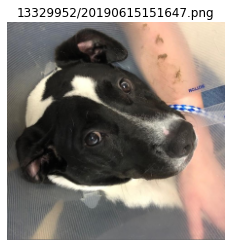

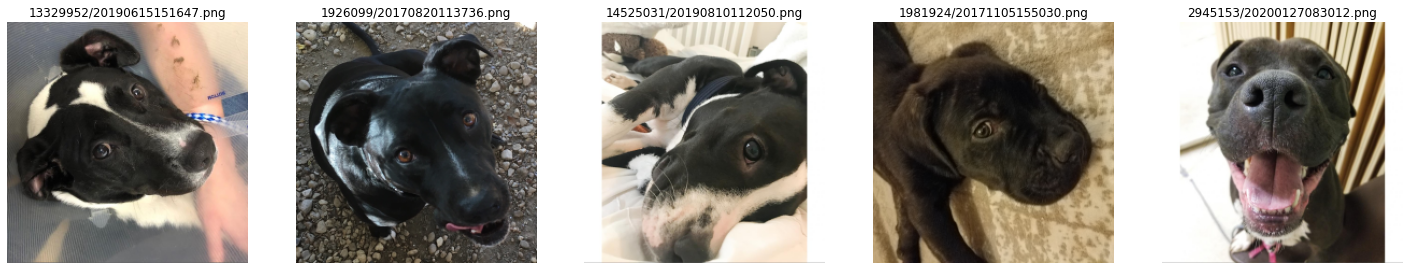

In [ ]:
# Example 1
p=700 
display_picture(id_to_name[p])
plt.savefig('./datasets/example_1_1.jpg')
display_results(search(xb[p]))
plt.savefig('./datasets/example_1_2.jpg')

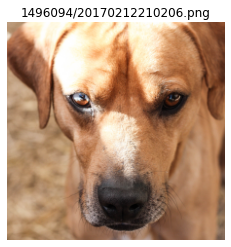

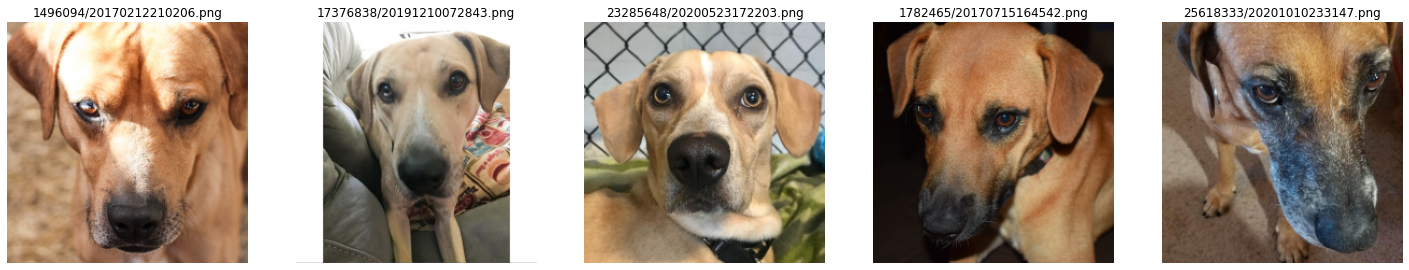

In [ ]:
# Example 2
p=1113
display_picture(id_to_name[p])
plt.savefig('./datasets/example_2_1.jpg')
display_results(search(xb[p]))
plt.savefig('./datasets/example_2_2.jpg')


## Try a noisy example with some dog-irrelevant features



In [ ]:
# Try a "noisier" image
download_file("https://storage.googleapis.com/dogs_img/unsplash.jpg", base_path="datasets", extract=False)

In [ ]:
IMG_SIZE = (224,224)
def get_newimage_emb(filepath): 
    model = EfficientNetB0(weights='imagenet', include_top=False, pooling="avg")
    cur_img = cv2.imread(filepath,cv2.IMREAD_UNCHANGED)  
    input_image = cv2.cvtColor(cv2.resize(cur_img, (224,224),interpolation = cv2.INTER_AREA),cv2.COLOR_BGRA2RGB)
    is_success, im_buf_arr = cv2.imencode(".jpg", input_image)
    input_image = im_buf_arr.tobytes()

    # input_image = tf.io.read_file(filepath)
    resized = tf.image.decode_jpeg(input_image, channels=3)
    resized = tf.image.convert_image_dtype(resized, tf.float32).numpy()
    pred = model.predict(resized.reshape(1,IMG_SIZE[0],IMG_SIZE[1],3))[0]

    return pred #embeddings to search 

In [ ]:
fname = "datasets/unsplash.jpg"
search_emb = get_newimage_emb(fname)

In [ ]:
list1 = search(search_emb, k= 5)

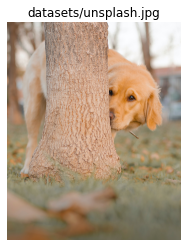

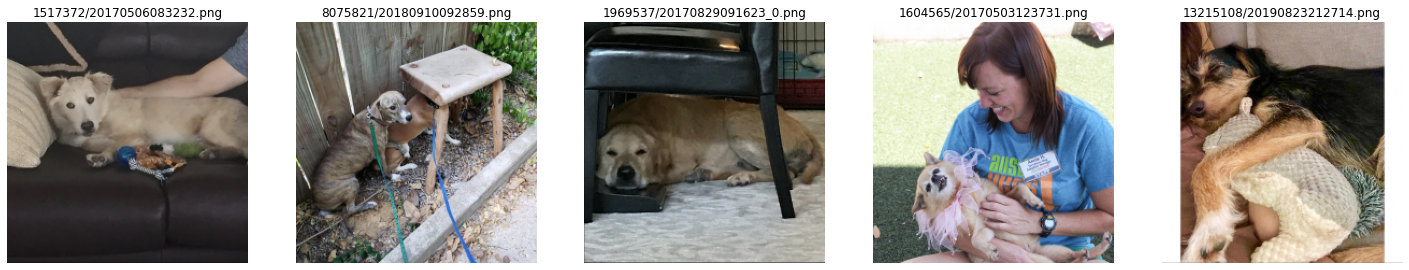

In [ ]:
# Example 3 
plt.imshow(plt.imread(fname))
plt.savefig('./datasets/example_3_1.jpg')
plt.title(fname)
plt.axis('off')
display_results(list1)
plt.savefig('./datasets/example_3_2.jpg')

**Note:** See here that because the input image has a tree in front of it, the seaarched embedding images have other confounding or dog-unspecific shape as well, such as chair, person, or arm.

In [ ]:
# Try Deep Lab to segement dog first and then do embedding search

trained_image_width=512 
mean_subtraction_value=127.5
image = plt.imread(fname)

# resize to max dimension of images from training dataset
w, h, _ = image.shape
ratio = float(trained_image_width) / np.max([w, h])
resized_image = np.array(Image.fromarray(image.astype('uint8')).resize((int(ratio * h), int(ratio * w))))

# apply normalization for trained dataset images
resized_image = (resized_image / mean_subtraction_value) - 1.

# pad array to square image to match training images
pad_x = int(trained_image_width - resized_image.shape[0])
pad_y = int(trained_image_width - resized_image.shape[1])
resized_image = np.pad(resized_image, ((0, pad_x), (0, pad_y), (0, 0)), mode='constant')

# make prediction
deeplab_model = Deeplabv3()
res = deeplab_model.predict(np.expand_dims(resized_image, 0))
labels = np.argmax(res.squeeze(), -1)

# remove padding and resize back to original image
if pad_x > 0:
    labels = labels[:-pad_x]
if pad_y > 0:
    labels = labels[:, :-pad_y]
labels = np.array(Image.fromarray(labels.astype('uint8')).resize((h, w)))

8986624/8986568 [==============================] - 0s 0us/step


<Figure size 432x288 with 0 Axes>

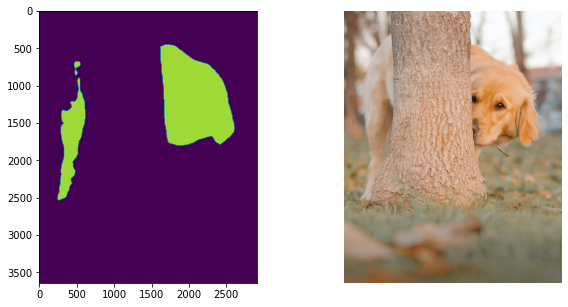

In [ ]:
# display segemented images
plt.figure()
f, ax = plt.subplots(1,2, figsize = (10,5)) 

ax[0].imshow(labels)
ax[1].imshow(image)
plt.axis('off')
plt.savefig('./datasets/example_4_1.jpg')

<Figure size 432x288 with 0 Axes>

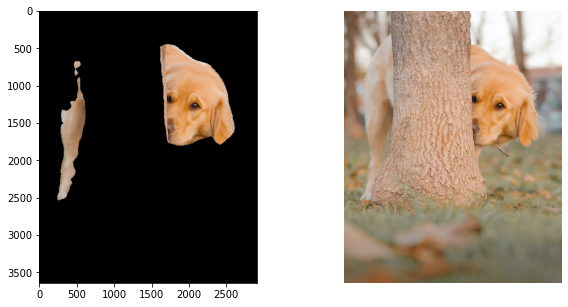

In [ ]:
## Remove background based on label and use it for embedding searching
labels[labels>0] = 1

plt.figure()
f, ax = plt.subplots(1,2, figsize = (10,5)) 
img_nobcgd = np.multiply(np.dstack((labels, labels, labels)),image)
ax[0].imshow(img_nobcgd)
ax[1].imshow(image)
plt.axis('off')
plt.savefig('./datasets/example_4_2.jpg')

In [ ]:
# save background removed image
cv2.imwrite(os.path.join(datasets_path, 'unsplash_nobcgd.jpg'), img_nobcgd)

True

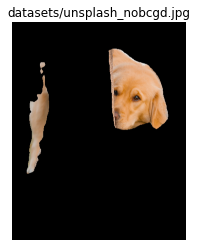

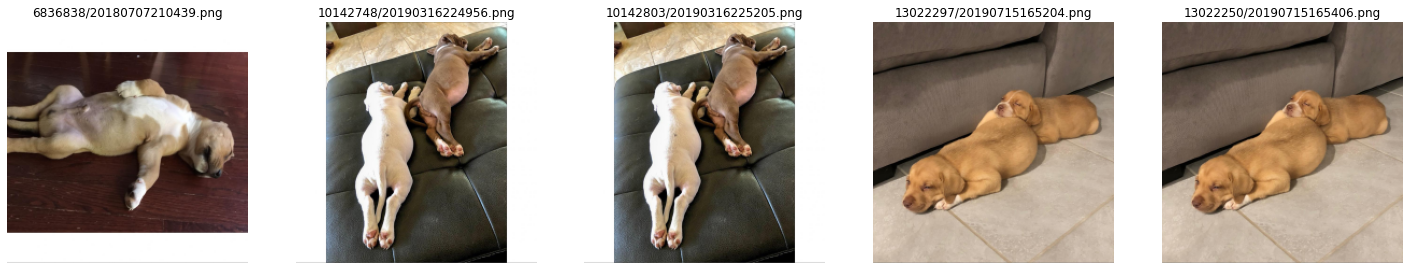

In [ ]:
fname = "datasets/unsplash_nobcgd.jpg"
search_emb = get_newimage_emb(fname)

list1 = search(search_emb, k= 5)

# Example 3 - Background removed
plt.imshow(cv2.imread(fname, cv2.COLOR_BGR2RGB))
plt.savefig('./datasets/example_5_1.jpg')
plt.title(fname)
plt.axis('off')
display_results(list1)
plt.savefig('./datasets/example_5_2.jpg')

**Note:** After segementating out dog-unspecific features, the searched images are a lot similar to the input image with more dog related characteristics matched, such as age, or color. 